In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# Useful Links
Implementing data object for neural networks:
https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

Writing a custom dataset class: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Writing a GAT Class example: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

Dataloaders for Batch Training: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Splitting datasets for training and testing: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

Batching with GNNs: https://github.com/pyg-team/pytorch_geometric/issues/973, https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(PPI).ipynb

Global Mean Pool: https://github.com/pyg-team/pytorch_geometric/discussions/3516

In [2]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [3]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [4]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torch_geometric.data.batch import Batch
from torch_geometric.data import Data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
%load_ext autoreload
from dataset import EMT_Dataset
dataset = EMT_Dataset(scRNA_data, string_2_protein)

Getting network tensor...


100%|██████████████████████████| 13715404/13715404 [00:05<00:00, 2342636.22it/s]


Getting node features tensor...


In [8]:
generator = torch.Generator().manual_seed(42)
train_length = int(0.7*len(dataset))
training_dataset, testing_dataset = random_split(dataset, [train_length, len(dataset)-train_length], generator=generator)

In [9]:
def graph_collate_fn(batch):
    node_features_list = []
    graph_list = []
    outputs_list = []
    counter = 0
    
    for ex in batch:
        node_feature, graph, output = ex
        num_nodes = node_feature.shape[0]
        node_features_list.append(node_feature)
        graph_list.append(graph + num_nodes*counter)
        outputs_list.append(output)
        counter += 1
    
    node_features = torch.stack(node_features_list, dim=0)
    node_features = torch.reshape(node_features, (node_features.shape[0]*node_features.shape[1], node_features.shape[2]))
    graphs = torch.cat(graph_list, 1)
    outputs = torch.stack(outputs_list, dim=0)
    
    return node_features, graphs, outputs

In [10]:
training_dataloader = DataLoader(training_dataset, batch_size=3, shuffle=True, collate_fn = graph_collate_fn)
testing_dataloader = DataLoader(testing_dataset, batch_size=3, shuffle=True, collate_fn = graph_collate_fn)

In [11]:
def get_tensor_batch(batch_num, num_nodes):
    tensor_batch = torch.tensor([i for i in range(batch_num) for _ in range(num_nodes)]).to(device)
    return tensor_batch

def GAT_train(model, dataloader, epochs, num_nodes, lr = 1e-3, weight_decay = 5e-4):
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss().to(device)
    model.train()
    optimizer.zero_grad()
    all_losses = []
    prev_batch_num = None
    
    for _ in tqdm(range(epochs)):
        losses = []
        
        for batch in dataloader:
            batch_num = batch[0].shape[0] // num_nodes
            
            if prev_batch_num != batch_num:
                prev_batch_num = batch_num
                tensor_batch = get_tensor_batch(prev_batch_num, num_nodes)
            
            node_features, graphs, outputs = batch 
            optimizer.zero_grad()
            
            graphs = graphs.to(device)
            node_features = node_features.to(device)
            outputs = outputs.to(device)
            out = model(node_features, graphs, tensor_batch)
            loss = criterion(out, outputs)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
          
        all_losses.append(sum(losses)/len(losses))
        
    plt.plot([i for i in range(1, (len(all_losses)+1))], all_losses)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('GATConv E/M classification Training') 

In [12]:
%reload_ext autoreload
from GAT import GAT
model = GAT(1, 16, dataset.num_classes(), 4).to(device)

  0%|                                                   | 0/500 [00:00<?, ?it/s]/home/nramani/BU/Crovella/Stefan_Mark/Constrative_Learning/GAT.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|█████████████████████████████████████████| 500/500 [07:45<00:00,  1.07it/s]


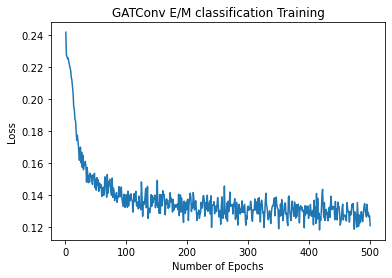

In [13]:
GAT_train(model, training_dataloader, 500, scRNA_data.shape[0])

In [14]:
def GAT_test(model, dataloader, num_nodes):
    test_losses = []
    fp, tp, fn, tn = 0, 0, 0, 0
    criterion = nn.MSELoss().to(device)
    prev_batch_num = None
    
    for batch in tqdm(dataloader):
        
        batch_num = batch[0].shape[0] // num_nodes
            
        if prev_batch_num != batch_num:
            prev_batch_num = batch_num
            tensor_batch = get_tensor_batch(prev_batch_num, num_nodes)
        
        node_features, graphs, outputs = batch
        
        graphs = graphs.to(device)
        node_features = node_features.to(device)
        outputs = outputs.to(device)
        
        out = model(node_features, graphs, tensor_batch)
            
        loss = criterion(out, outputs)
        
        test_losses.append(loss.item())
        
    return sum(test_losses)/len(test_losses)

In [15]:
GAT_test(model, testing_dataloader, scRNA_data.shape[0])

100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 274.49it/s]


0.13124683734349674

In [16]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x)
        return x

In [25]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=True)
mlp = MLP(dataset.num_nodes(), 16, dataset.num_classes()).to(device)

In [26]:
def MLP_train(model, dataloader, epochs, lr = 1e-8, weight_decay = 5e-4):
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss().to(device)
    model.train()
    optimizer.zero_grad()
    all_losses = []
    
    for _ in tqdm(range(epochs)):
        model = model.train()
        losses = []
        
        for batch in dataloader:
            node_features, _, outputs = batch
            node_features = torch.reshape(node_features, (node_features.shape[0], node_features.shape[1])).to(device)
            outputs = outputs.to(device)
            out = model(node_features)
            loss = criterion(out, outputs)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        all_losses.append(sum(losses)/len(losses))
            
    plt.plot([i for i in range(1, (len(all_losses)+1))], all_losses)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('MLP E/M classification Training') 

  0%|                                                   | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_9662/3906318802.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|█████████████████████████████████████████| 500/500 [00:36<00:00, 13.52it/s]


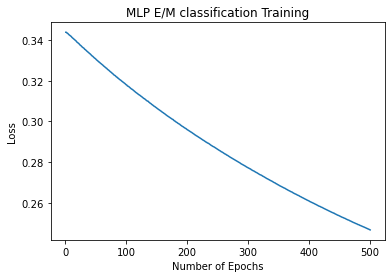

In [27]:
MLP_train(mlp, training_dataloader, 500)

In [28]:
def MLP_test(model, dataloader):
    test_losses = []
    fp, tp, fn, tn = 0, 0, 0, 0
    criterion = nn.MSELoss().to(device)
    
    for batch in tqdm(dataloader):
        node_features, _, outputs = batch
        node_features = torch.reshape(node_features, (node_features.shape[0], node_features.shape[1])).to(device)
        outputs = outputs.to(device)
        out = model(node_features)
        loss = criterion(out, outputs)
        test_losses.append(loss.item())
        
    return sum(test_losses)/len(test_losses)

In [29]:
MLP_test(mlp, testing_dataloader)

  0%|                                                     | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_9662/3906318802.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 184.99it/s]


0.24752537161111832

# Contrastive Learning

In [30]:
training_dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=2, shuffle=True)

In [151]:
class GAT_Contrast(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        
        self.gat1 = GATConv(in_channels, hidden_channels, heads, dropout = 0.6)
        self.output_layer1 = nn.Linear(2*hidden_channels*out_channels*heads, 1)
        self.output_layer2 = nn.Linear(1, 1)
        self.gat2 = GATConv(in_channels, hidden_channels, heads, dropout = 0.6)

    def forward(self, x1, edge_index1, x2, edge_index2):
        x1 = self.gat1(x1, edge_index1)
        x1 = F.relu(x1)
        
        x2 = self.gat2(x2, edge_index2)
        x2 = F.relu(x2)
        #print(x1.shape, x2.shape)
        x = torch.stack((x1, x2))
        x = torch.flatten(x)
        #print(x.shape)
        x = self.output_layer1(x)
        x = self.output_layer2(x)
        #print(x)
        #x = F.softmax(x)
        return x   

In [155]:
from torch_geometric.nn import GATConv

def GAT_contrast_train(model, dataloader, epochs, num_nodes, lr = 1e-3, weight_decay = 5e-4):
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss().to(device)
    model.train()
    optimizer.zero_grad()
    all_losses = []
    
    for _ in tqdm(range(epochs)):
        losses = []
        
        for batch in dataloader:
            try:
                x1, edge_index1 = batch[0][0].to(device), batch[1][0].to(device)
                x2, edge_index2 = batch[0][1].to(device), batch[1][1].to(device)
            except IndexError:
                continue
            
            if torch.equal(batch[2][0], batch[2][1]):
                outputs = torch.tensor([1.0]).to(device)
            else:
                outputs = torch.tensor([0.0]).to(device)
            #print(outputs)
            optimizer.zero_grad()
    
            out = model(x1, edge_index1, x2, edge_index2)
            #print(out, outputs)
            loss = criterion(out, outputs)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        #print(sum(losses)/len(losses))
        all_losses.append(sum(losses)/len(losses))
        
    plt.plot([i for i in range(1, (len(all_losses)+1))], all_losses)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('GATConv Contrastive Training')

In [156]:
gat_contrast = GAT_Contrast(1, 16, dataset.num_nodes(), 1).to(device)

100%|█████████████████████████████████████████| 500/500 [07:31<00:00,  1.11it/s]


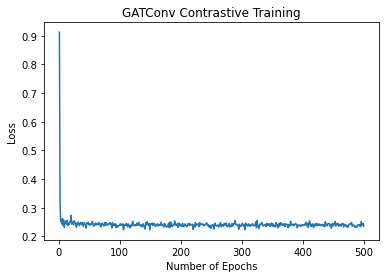

In [157]:
GAT_contrast_train(gat_contrast, training_dataloader, 500, scRNA_data.shape[0])